In [1]:
import pandas as pd
import sklearn
import sklearn.ensemble
import numpy as np
import seaborn as sns
from pylab import savefig
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from pathlib import Path
import math
from sklearn.model_selection import train_test_split

In [2]:
a0 = pd.read_csv('A0.csv', header = None, names=['Y','X'])
b0 = pd.read_csv('B0.csv', header = None, names=['Y','X'])
#these next two lines swap the columns, so the order is less confusing
a0 = a0[["X","Y"]]
b0 = b0[["X","Y"]]
data_orig = pd.read_csv('data.csv', header = None)

height, width = data_orig.shape
a0length = a0.shape[0]
b0length = b0.shape[0]


In [3]:
def getValue(x,y):
    if (0 <= x < data_orig.shape[0] and 0 <= y < data_orig.shape[1]):
        return data_orig.iloc[x,y]
    return -1

In [4]:
def printClassMetrics(data, name: str):
    values = []
    for index, k in data.iterrows():
        x,y = k
        values.append(data_orig.iloc[x,y])
    values.sort()
    print(f"""
Anzahl {name}-Punkte:  {len(values)}
minimum:        {values[0]}
maximum:        {values[-1]}
arithm. Mittel: {sum(values) / len(values)}
Median:         {np.median(values)}
StdAbweichung:  {np.std(values)}
Varianz:        {np.var(values)}\n""")

printClassMetrics(a0, "A")
printClassMetrics(b0, "B")


Anzahl A-Punkte:  980
minimum:        280.35400000000004
maximum:        758.19
arithm. Mittel: 538.2508765306122
Median:         528.9055
StdAbweichung:  66.67809044578271
Varianz:        4445.96774549598


Anzahl B-Punkte:  405
minimum:        242.329
maximum:        687.703
arithm. Mittel: 488.64383950617264
Median:         484.801
StdAbweichung:  58.21089063109755
Varianz:        3388.5077880656004



Aus diesen Metriken allein können wir kaum zuverlässige schlüsse ziehen, abgesehen von der Tatsache, dass die B-Punkte etwas tiefer auf dem Bild liegen. Außerdem finden sich auf dem Bild mehr als doppelt so viele A-, wie B-punkte.

In [29]:
#finding the shortest distances between two points in both a- and b-pointsl. Distance is measured 
#in the "pixels" of data.csv 
allpoints = pd.concat([a0,b0])
length= int(allpoints.shape[0]/3)
alldistances = []
for i in range(length-1):
    if i % 60 == 0:
        print(f"looking at {i} of {length}")
    x1, y1 = getcoordinatesforindex(allpoints,i)
    for j in range(i+1,length):
        x2, y2 = getcoordinatesforindex(allpoints,j)
        diff = math.sqrt((x2-x1)**2+(y2-y1)**2)
        alldistances.append((diff,x1,y1))

alldistances = sorted(alldistances, key=lambda x: x[0])
print(f"shortest distance is: {alldistances[0][0]} at indexes {alldistances[0][1:]}")
print(alldistances[:5])

[(14.7648230602334, 2238, 1681), (22.47220505424423, 557, 3395), (24.166091947189145, 400, 925), (24.596747752497688, 905, 1047), (24.596747752497688, 809, 1176)]


## Ergebnis:
Dieser Versuch zeigt auf, dass die kürzeste Entfernung zwischen zwei Punkten (egal ob a oder b) bei 14.8 px liegt. Die kürzesten 15 Punkte liegen weniger als 38 px voneinander entfernt. Dies können wir nutzen, um sicher zu stellen, dass wir im richtigen Radius um einen gegebenen Punkt herum nach weiteren Höhepunkten auf dem Datenfeld (im Folgenden hügel genannt) suchen. Wir werden an dieser Stelle den ersten Punkt als statistische Anomalie betrachten, und die Versuche mit einem Suchradius von etwa 20 beginnen, um den größtmöglichen Bildausschnitt betrachten zu können, ohne mehrere Hügel in einem Bild zu haben.

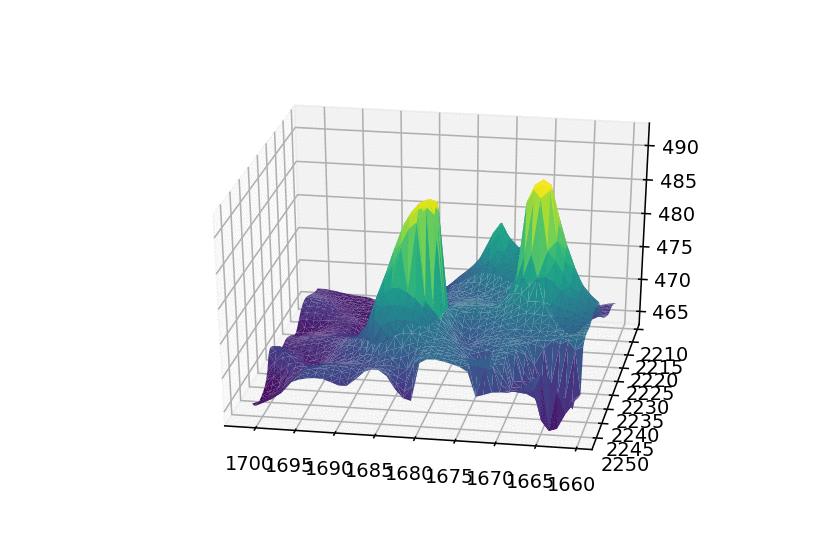
### Die beiden Punkte mit der Geringsten Entfernung

## Watch out!
for any of the following cells to work, a folder called "gen" needs to exist in the same directory as the notebook!


In [15]:
#functionality to plot a rotating 3d image of indices k.
#will generate a number of slightly rotated images to /gen and then collect
#them to a single .gif

def plot3Dgraph(indices,dataset:str='b0',searchrange=20):

    datapoints = eval(dataset)

    #index of datapoint
    for k in (indices):
        x, y = getcoordinatesforindex(datapoints, k)

        xstart = x - searchrange
        xend = x + searchrange +1
        ystart = y - searchrange
        yend = y + searchrange +1


        # Transform data to a long format
        df=data_orig.iloc[xstart:xend,ystart:yend].unstack().reset_index()
        df.columns=["X","Y","Z"]


        # And transform the old column name in something numeric
        #df['X']=pd.Categorical(df['X'])
        #df['X']=df['X'].cat.codes

        # We are going to do 20 plots, for 20 different angles
        print("generating different angles...")
        for angle in range(40,240,3):

            fig = plt.figure()

            ax = fig.gca(projection='3d')
            ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)

            #option for scatterplot (not actually useful...)
            #ax.scatter(df['Y'], df['X'], df['Z'], c ='blue', s=8)

            # Set the angle of the camera
            ax.view_init(30,angle)

            # Save it
            filename=f'gen/Image{k}_{angle}.png'
            plt.savefig(filename, dpi=140)
            plt.gca()
            plt.close(fig)


        fig.clf()
        print("collecting images to gif...")
        #collect all images to a gif

        bashCommand = f"convert -delay 50 gen/Image{k}*.png gen/animated_3DPlot_{dataset}_index-{k}_searchrange-{searchrange}.gif"
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

        #delete obsolete images
        print("deleting old images...")
        for p in Path(".").glob(f"gen/Image{k}*.png"):
            p.unlink()
        print(f"k = {k} done.\n")
    print("all images generated.")  

In [ ]:
print("starting to unstack data...")
data_scaled = data_orig.iloc[::20,::20]
df=data_scaled.unstack().reset_index()
df.columns=["X","Y","Z"]


# And transform the old column name in something numeric
#df['X']=pd.Categorical(df['X'])
#df['X']=df['X'].cat.codes
k = 1
# We are going to do 20 plots, for 20 different angles
print("generating different angles...")
for angle in range(40,240,5):
    print(f"generating angle {angle}")
    fig = plt.figure()

    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)

    #option for scatterplot (not actually useful...)
    #ax.scatter(df['Y'], df['X'], df['Z'], c ='blue', s=8)

    # Set the angle of the camera
    ax.view_init(30,angle)

    # Save it
    filename=f'gen/Image_{angle}.png'
    plt.savefig(filename, dpi=100)
    plt.gca()
    plt.close(fig)


fig.clf()
print("collecting images to gif...")
#collect all images to a gif

bashCommand = f"convert -delay 50 gen/Image{k}*.png gen/animated_3DPlot_entire_dataset.gif"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

#delete obsolete images
print("deleting old images...")
for p in Path(".").glob(f"gen/Image{k}*.png"):
    p.unlink()
print(f"k = {k} done.\n")
print("all images generated.")  

In [35]:
data_scaled = data_orig.iloc[::2,::2]
print(data_scaled.shape,data_orig.shape)

(2472, 1500) (4943, 3000)


In [ ]:
plot3Dgraph([128],'b0')

In [14]:
#functionality to display a heatmap of indices k.
#will save the image into the /gen folder
def plotHeatmap(indices,dataset:str='b0',searchrange=20):

    datapoints = eval(dataset)

    for k in indices:
        x, y = getcoordinatesforindex(datapoints,k)
        xstart = x - searchrange
        xend = x + searchrange +1
        ystart = y - searchrange
        yend = y + searchrange +1
        focusarea = data_orig.iloc[xstart:xend, ystart:yend]
        heatmap = sns.heatmap(pd.DataFrame(focusarea, index = None, columns = None), yticklabels=False, 
                            xticklabels=False, cbar=False)

        imagename =f"gen/heatmap_{dataset}_index-{k}_searchrange-{searchrange}.png"

        plt.savefig(imagename, dpi=500)
        plt.clf()

In [6]:
def getcoordinatesforindex(data,index):
    return (data.iloc[index,1],data.iloc[index,0])

In [13]:
#we use this cell to prove our theory, that the classified points are not necessarily 
#the summit of a "hill", but simply some point on it.


searchrange = 2

for k in range (0,8):
    
    x ,y = getcoordinatesforindex(b0,k)
    print(f"looking at {(x,y)}")
    xstart = x - searchrange
    xend = x + searchrange +1
    ystart = y - searchrange
    yend = y + searchrange +1
    value = data_orig.iloc[x,y]
    for i in range(xstart, xend):
        for j in range(ystart, yend):
            if data_orig.iloc[i,j] > value:
                print(f"\t{i,j} is larger than {x,y}")

looking at (2094, 2363)
looking at (1053, 2254)
	(1053, 2255) is larger than (1053, 2254)
looking at (3346, 2264)
looking at (2509, 327)
looking at (2962, 937)
looking at (424, 535)
	(424, 536) is larger than (424, 535)
looking at (1766, 2231)
looking at (3762, 639)


In [9]:
def normalizeAroundCenter(dataframe: pd.DataFrame):
    x = int(dataframe.shape[1]/2)
    y = int(dataframe.shape[0]/2)
    centervalue = dataframe.iloc[x,y]
    print(dataframe -centervalue)

In [11]:
dataframe = data_orig.iloc[1000:1005,1000:1005]
print(dataframe)
print(normalizeAroundCenter(dataframe))

         1000     1001     1002     1003     1004
1000  510.250  511.439  518.423  519.582  520.618
1001  509.834  515.687  518.129  519.060  519.760
1002  509.291  515.475  517.462  518.342  518.922
1003  508.568  515.107  516.647  517.529  518.163
1004  507.642  514.821  515.821  516.681  517.378
       1000   1001   1002   1003   1004
1000 -7.212 -6.023  0.961  2.120  3.156
1001 -7.628 -1.775  0.667  1.598  2.298
1002 -8.171 -1.987  0.000  0.880  1.460
1003 -8.894 -2.355 -0.815  0.067  0.701
1004 -9.820 -2.641 -1.641 -0.781 -0.084
None


In [24]:
def calculateSteigungen(x,y, steps, stepSize):
    steigungen = []
    center = data_orig.iloc[x,y]
    previous = [center,center,center,center]
    
    for step in range(1,steps+1):
        d = step*stepSize
        steigungen.append(steigung(x-d,y,previous,0,stepSize))
        steigungen.append(steigung(x+d,y,previous,1,stepSize))
        steigungen.append(steigung(x,y-d,previous,2,stepSize))
        steigungen.append(steigung(x,y+d,previous,3,stepSize))
    return steigungen


def steigung(x,y,previous,i,d):
    v = getValue(x,y)
    focus = previous[i]
    previous[i] = v
    if v < 0:
        return 0
    return math.degrees(np.arctan((v - focus)/d))

## ShiftSteigungen()
Diese Methode nutzen wir dafür, die Anzahl der Trainingsdaten zu erhöhen, indem wir die Steigungen um alle Punkte in allen der vier möglichen Ausrichtungen darstellen. Dies führte in ersten Versuchen zu einer deutlichen Verbesserung der Ergebnisse

In [32]:
def shiftSteigungen(df):
    result = df
    cols = df.columns.tolist()
    for k in range (3):
        for i in range (0,len(cols)-1,4):
            swapcolumns(cols,i)
        df1 = df[cols]
        result = pd.concat([result, df1])
    return result

def swapcolumns(cols, i):
    first = cols[i]
    for j in range (3):
        cols[i + j] = cols[i+1 + j]
    cols[i+3] = first

In [82]:
forst = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

## Erfassung der Daten für die Random-forest Klassifikation

In [83]:
points = []
for i in range(a0length):
    list = calculateSteigungen(a0.iloc[i,1],a0.iloc[i,0],3,5)
    list.append('a')
    points.append(list)

for i in range(b0length):
    list = calculateSteigungen(b0.iloc[i,1],b0.iloc[i,0],3,5)
    list.append('b')
    points.append(list)
    
points = np.array(points)
pointslabelled = pd.DataFrame(points)

## Aufbereitung der Daten

In [84]:
ptrain, ptest =  train_test_split(pointslabelled, test_size=0.2)
ptrain = shiftSteigungen(ptrain)
lables = ptrain.iloc[:,-1]
features = ptrain.columns[:-1]

(4432, 13)


## Training des Klassifikators

In [85]:
forst.fit(ptrain[features],lables)
predictions = forst.predict(ptest[features])
ct = pd.crosstab(ptest.iloc[:,-1],predictions, rownames=['actual'], colnames=['predicted'])

## Nutzen der Funktion shiftSteigungen():
Bei der Erhaltung aller anderen Parameter verbessert die Rotation der Trainingspunkte das Ergebnis merklich. Ohne Rotation erhalten wir Präzisionen von (65.93406593406593, 8.60215053763441), mit Rotation eine Präz von (72.22222222222221 7.317073170731707)


In [86]:
print(ct)
TN = ct.iloc[0,0]
TP = ct.iloc[1,1]
FP = ct.iloc[0,1]
FN = ct.iloc[1,0]
btotal = TP + FN
atotal = FP + TN
tpperc = (TP/btotal)*100
fpperc = (FP/atotal)*100
print("Prozentuale Anzahl an True Positives: ", tpperc,'%')
print("Prozentuale Anzahl an False Positives: ", fpperc,'%')

predicted    a   b
actual            
a          182  16
b           24  55
Prozentuale Anzahl an True Positives:  69.62025316455697 %
Prozentuale Anzahl an False Positives:  8.080808080808081 %
